In [76]:
from commons import *

# 1. Additivity Assumption
Is it true that we can just add up pre-processor runtime and classifier runtime?

In [305]:
plDF = pd.read_csv("data/rawruntimes/runtimes_pipelines.csv", delimiter=";")
mlDF = pd.read_csv("data/runtimes_meta_default.csv")
baDF = pd.read_csv("data/runtimes_all_default_nooutliers.csv")
mfDF = pd.read_csv("data/metafeaturetransformations.csv")
meDF = pd.read_csv("data/metalearner_parametereffects.csv")

In [78]:
preprocessors = pd.unique(plDF["preprocessor"])

In [79]:
basealgorithms = pd.unique(baDF["algorithm"])

In [5]:
deviationsWithPP = []
deviationsWithoutPP = []
plDF = plDF[pd.notnull(plDF["traintime"])]
plDF = plDF.query("traintime >= 10")
pbar = tqdm(total=len(plDF))
for i, row in plDF.iterrows():
    pbar.update(1)
    ml = row["metalearner"]
    bl = row["baselearner"]
    if pd.notnull(ml):
        mlName = ml.split(".")[-1].lower()
        lRuntime = mlDF.query("openmlid == " + str(row["openmlid"]) + " and seed == " + str(row["seed"]) + " and fitsize == " + str(row["datapoints"]) + " and algorithm == '" + mlName + "' and baselearner == '" + bl + "'")
        blName = bl
    else:
        blName = bl.split(".")[-1].lower()
        if blName == "decisionstump":
            blName = "ds"
        if blName == "decisiontable":
            blName = "dt"
        if blName == "multilayerperceptron":
            blName = "ann"
        if blName == "naivebayes":
            blName = "nb"
        if blName == "naivebayesmultinomial":
            blName = "nbm"
        lRuntime = baDF.query("openmlid == " + str(row["openmlid"]) + " and seed == " + str(row["seed"]) + " and fitsize == " + str(row["datapoints"]) + " and algorithm == '" + blName + "'")

    if len (lRuntime) > 0:
        lTraintime = lRuntime["fittime"].values[0]
        lApplicationtime = lRuntime["applicationtime"].values[0]
        
        pp = row["preprocessor"]
        if pd.notnull(pp):
            if pp == "CfsSubsetEval/bfs":
                ppName = "bf/cfssubseteval"
            if pp == "CfsSubsetEval/gsw":
                ppName = "gsw/cfssubseteval"
            if pp == "CorrelationAttributeEval":
                ppName = "correlationAS"
            if pp == "GainRatioAttributeEval":
                ppName = "GainRatioAS"
            if pp == "InfoGainAttributeEval":
                ppName = "InfoGainAS"
            if pp == "OneRAttributeEval":
                ppName = "OneRAS"
            if pp == "PrincipalComponents":
                ppName = "PCAAS"
            if pp == "ReliefFAttributeEval":
                ppName = "ReliefFAS"
            if pp == "SymmetricalUncertAttributeEval":
                ppName = "SymmetricalUncertAS"
            if ppName == None:
                raise Exception()
            ppRuntime = baDF.query("openmlid == " + str(row["openmlid"]) + " and seed == " + str(row["seed"]) + " and fitsize == " + str(row["datapoints"]) + " and algorithm == '" + ppName + "'")
            if len(ppRuntime) > 0:
                maxAtts = np.max(ppRuntime["fitattributes"].values)
                ppRuntime = ppRuntime[ppRuntime["fitattributes"] == maxAtts]
                ppTraintime = ppRuntime["fittime"].values[0]
                ppApplicationtime = ppRuntime["applicationtime"].values[0]
        else:
            ppTraintime = 0
            ppApplicationtime = 0
            ppName = ""
        
        totalTraintime = lTraintime + ppTraintime
        totalApplicationtime = lApplicationtime + ppApplicationtime
        totalComposedRuntime = totalTraintime# + totalApplicationtime
        totalTrueRuntime = row["traintime"]# + row["testtime"]
        plDesc = ppName + "/" + mlName + "/" + blName
        if pd.isnull(pp):
            dev = totalTrueRuntime-totalComposedRuntime
            deviationsWithoutPP.append(dev)
            if np.abs(dev) > 60:
                print(plDesc + " on openmlid " + str(row["openmlid"]) + " and seed " + str(row["seed"]) + " and " + str(row["datapoints"]) + " trainpoints. Composed gives " + str(totalComposedRuntime) + " where true is " + str(totalTrueRuntime))
        else:
            deviationsWithPP.append(totalTrueRuntime-totalComposedRuntime)
           # print(str(row["openmlid"]) + "/" + plDesc + ": "+ str(totalComposedRuntime) + "/" + str(totalTrueRuntime))
pbar.close()

/adaboostm1/weka.classifiers.rules.DecisionTable on openmlid 1242 and seed 0 and 10000 trainpoints. Composed gives 272.0 where true is 205.0
/adaboostm1/weka.classifiers.rules.DecisionTable on openmlid 4541 and seed 0 and 50000 trainpoints. Composed gives 110.0 where true is 520.0
/adaboostm1/weka.classifiers.lazy.IBk on openmlid 4541 and seed 0 and 10000 trainpoints. Composed gives 320.0 where true is 18.0
/adaboostm1/weka.classifiers.trees.LMT on openmlid 4541 and seed 0 and 1000 trainpoints. Composed gives 1221.0 where true is 1144.0
/adaboostm1/weka.classifiers.rules.DecisionTable on openmlid 4541 and seed 1 and 50000 trainpoints. Composed gives 504.0 where true is 346.0
/adaboostm1/weka.classifiers.functions.Logistic on openmlid 4541 and seed 0 and 100 trainpoints. Composed gives 181.0 where true is 36.0
/adaboostm1/weka.classifiers.rules.DecisionTable on openmlid 273 and seed 0 and 1000 trainpoints. Composed gives 487.0 where true is 121.0
/adaboostm1/weka.classifiers.rules.Decis

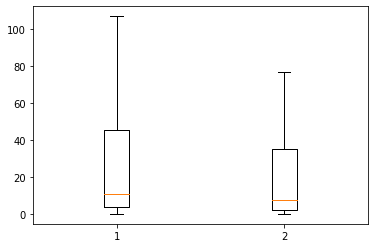

In [143]:
plt.boxplot([np.abs(deviationsWithPP), np.abs(deviationsWithoutPP)], 0, "")
pass

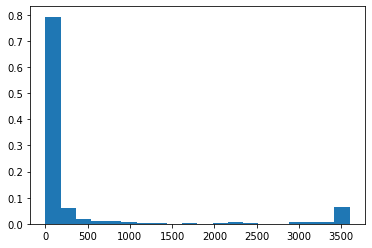

In [117]:
plt.hist(deviationsWithPP, bins=20, weights=np.ones(len(deviationsWithPP)) / len(deviationsWithPP))
pass

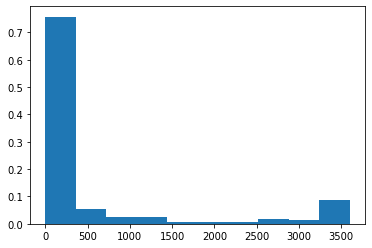

In [116]:
plt.hist(deviationsWithoutPP, bins=10, weights=np.ones(len(deviationsWithoutPP)) / len(deviationsWithoutPP))
pass

# 2. Predictions

In [417]:
import time
class PLPredictor:
    
    def __init__(self, numtrees = 100):
        self.numtrees = numtrees
        self.trueRuntimes = pd.DataFrame([], columns=["openmlid", "algorithm", "algorithmoptions", "fitsize", "fitattributes", "fittime", "applicationtimeperinstance"])
    
    def tellRuntime(self, openmlid, basealgorithm, options, fitsize, fitattributes, fittime, applicationtimeperinstance):
        self.trueRuntimes.loc[len(self.trueRuntimes)] = [openmlid, basealgorithm, options, fitsize, fitattributes, fittime, applicationtimeperinstance]
    
    def build(self, badataDefault, badataParametrized, mfdata, mldata):
        models = {}
        self.models = models
        models["ba"] = {}
        self.datasets = list(pd.unique(badataDefault["openmlid"]))
        self.datasets.extend(pd.unique(badataParametrized["openmlid"]))
        self.datasets.extend(pd.unique(mfdata["openmlid"]))
        self.datasets.extend(pd.unique(mldata["openmlid"]))
        
        
        ###
        ### Build models for meta-learner parameters
        ###
        metalearners = pd.unique(mldata["algorithm"])
        models["ml"] = {}
        for ml in metalearners:
            models["ml"][ml] = {}
            trainDF = mldata[mldata["algorithm"] ==  ml].copy()
            trainDF["testpoints"] = trainDF["numinstances"] - trainDF["trainpoints"]
            trainDF["I"] = [int(x.split(" ")[x.split(" ").index("-I") + 1]) for x in trainDF["algorithmoptions"]]
            features = ["trainpoints", "numattributes", "testpoints", "I"]
            
            if ml in ["adaboostm1", "bagging", "logitboost", "randomsubspace"]:
                trainDF["P"] = [int(x.split(" ")[x.split(" ").index("-P") + 1]) for x in trainDF["algorithmoptions"]]
                trainDF["instportion"] = trainDF["trainpoints"] * trainDF["P"] / 100
                trainDF["attportion"] = np.round(trainDF["numattributes"] * trainDF["P"] / 100)
                features.extend(["P", "instportion", "attportion"])
                
            for param in ["builds", "numinstances_sub", "numattributes_sub", "predictioncalls_training", "predictioncalls_prediction"]:
                lr = sk.linear_model.LinearRegression()
                X = trainDF[features]
                Y = trainDF[param] if param != "numattributes_sub" or ml != "randomsubspace" else X["attportion"].values
                Xtrain, Xtest, Ytrain, Ytest = sk.model_selection.train_test_split(X, Y)
                lr.fit(Xtrain, Ytrain)
                p = lr.predict(Xtest)
                errors = np.round(np.abs(p - Ytest))
                if len(errors[errors > 0]) > 0:
                    raise Exception("Could not train precise model for " + param + " of " + ml + ". Prediction errors:\n" + str(errors))
                models["ml"][ml][param] = lr
        
        ###
        ### Build runtime models for base algorithms under DEFAULT parametrization
        ###
        basealgorithms = pd.unique(badataDefault["algorithm"])
        for ba in tqdm(basealgorithms):
            models["ba"][ba] = {}
            trainDF = badataDefault[badataDefault["algorithm"] == ba]
            
            # model for train time
            rf = sk.ensemble.RandomForestRegressor(n_estimators=self.numtrees)
            X = trainDF[["fitsize", "fitattributes"]]
            Y = trainDF["fittime"]
            rf.fit(X, Y)
            models["ba"][ba]["fit"] = rf
           

            # model for prediction time
            rf = sk.ensemble.RandomForestRegressor(n_estimators=self.numtrees)
            trainDF = trainDF[["fitsize", "fitattributes", "applicationtime", "applicationsize"]].dropna()
            X = trainDF[["fitsize", "fitattributes"]]
            Y = 10000 * trainDF["applicationtime"] / trainDF["applicationsize"]
            rf.fit(X, Y)
            models["ba"][ba]["predict"] = rf
            
        ###
        ### Build runtime models for base algorithms under CUSTOM parametrization
        ###
        basealgorithms = pd.unique(badataParametrized["algorithm"])
        for ba in tqdm(basealgorithms):
            models["ba"][ba] = {}
            trainDF = badataParametrized[badataParametrized["algorithm"] == ba]
            
            # model for train time
            rf = sk.ensemble.RandomForestRegressor(n_estimators=self.numtrees)
            X = trainDF[["fitsize", "fitattributes", "<specific options of this base algorithm>", "<default runtime of this learner>"]]
            Y = trainDF["fittime"]
            rf.fit(X, Y)
            models["ba"][ba]["fit"] = rf
           

            # model for prediction time
            rf = sk.ensemble.RandomForestRegressor(n_estimators=self.numtrees)
            trainDF = trainDF[["fitsize", "fitattributes", "applicationtime", "applicationsize"]].dropna()
            X = trainDF[["fitsize", "fitattributes"]]
            Y = 10000 * trainDF["applicationtime"] / trainDF["applicationsize"]
            rf.fit(X, Y)
            models["ba"][ba]["predict"] = rf
        
        ###
        ### Build meta-feature transformation models for pre-processors
        ###
        preprocessors = [x for x in basealgorithms if x in ['bf/cfssubseteval', 'gsw/cfssubseteval', 'correlationAS', 'GainRatioAS', 'InfoGainAS', 'PCAAS', 'ReliefFAS', 'SymmetricalUncertAS', 'OneRAS']]
        models["mf"] = {}
        for pp in preprocessors:
            trainDF = mfdata[mfdata["algorithm"] == pp]
            rf = sk.ensemble.RandomForestRegressor(n_estimators=self.numtrees)
            X = trainDF[["numattributes_before"]]
            Y = trainDF["numattributes_after"]
            rf.fit(X, Y)
            models["mf"][pp] = rf

            
    def predictRuntime(self, componentInstance, openmlid, Dtrain, Deval):
    
        if openmlid in self.datasets:
            raise Exception("Biased predictor, has seen values for this dataset before!")
    
        # initial meta features
        numInstancesTrain = Dtrain.shape[0]
        numAttributes = Dtrain.shape[1]
        numInstancesEval = Deval.shape[0]

        # get pre-processor runtime and modified number of features for learner
        if componentInstance['preprocessor'] != None:
            pp = componentInstance['preprocessor']
            ppTrainPrediction = self.models["ba"][pp]["fit"].predict(np.array([[numInstancesTrain, numAttributes]]))
            ppApplyPrediction = self.models["ba"][pp]["predict"].predict(np.array([[numInstancesEval, numAttributes]]))
            ppRuntime = ppTrainPrediction + ppApplyPrediction
            numAttributes = int(np.round(self.models["mf"][pp].predict(np.array([[numAttributes]]))[0]))
        else:
            ppRuntime = 0
            
        # meta features for base learner: if there is a meta learner, prepare meta features for base learner
        ml = componentInstance['metalearner']
        if ml != None:
            if type(ml) == str: # default parametrization
                mlName = ml.split(".")[-1].lower()
                mlOptions = "-I 10"
                if mlName in ["adaboostm1", "bagging", "logitboost", "randomsubspace"]:
                    mlOptions += " -P 100"
                
            else: # parametrized variant
                mlOptions = ml[1]
                mlName = ml[0]
            I = int(mlOptions.split(" ")[mlOptions.split(" ").index("-I") + 1])
            P = int(mlOptions.split(" ")[mlOptions.split(" ").index("-P") + 1]) if "-P" in mlOptions else None
            features = [numInstancesTrain, numAttributes, numInstancesEval, I]
            if P != None:
                features.extend([P, numInstancesTrain * P / 100, numAttributes * P / 100])
            features = [features]
            
            # predict params
            k = np.round(self.models["ml"][mlName]["builds"].predict(features)[0])
            predictionCallsInTrainPhase = np.round(self.models["ml"][mlName]["predictioncalls_training"].predict(features)[0])
            predictionCallsInPredictPhase = np.round(self.models["ml"][mlName]["predictioncalls_prediction"].predict(features)[0])
            numInstancesTrain = np.round(self.models["ml"][mlName]["numinstances_sub"].predict(features)[0])
            numAttributes = np.round(self.models["ml"][mlName]["numattributes_sub"].predict(features)[0])
        
        
        # get parametrization of base learner
        bl = componentInstance["baselearner"]
        if type(bl) == str: # if the bl has default parametrization
            blName = bl.split(".")[-1].lower()
            blOptions = None
        else:
            blName = bl[0].split(".")[-1].lower()
            blOptions = bl[1]
        
        # get runtime for base learner 
        blTrueRuntimes = self.trueRuntimes.query("openmlid == " + str(openmlid) + " and algorithm == '" + blName + "' and fitsize == " + str(numInstancesTrain) + " and algorithmoptions == '" + str(blOptions) + "' and fitattributes == " + str(numAttributes)).head(1)
        if len(blTrueRuntimes) > 0: # if we already know the true runtime of this base learner (in the requested configuration), directly use it
            blTrainPrediction = blTrueRuntimes["fittime"].values[0]
            blPredictPrediction = blTrueRuntimes["applicationtimeperinstance"].values[0] * numInstancesEval 
        else:
            if blOptions == None: # if the learner is used with default parametrization
                blTrainPrediction = self.models["ba"][bl]["fit"].predict(np.array([[numInstancesTrain, numAttributes]]))[0]
                blPredictPrediction = self.models["ba"][bl]["predict"].predict(np.array([[numInstancesTrain, numAttributes]]))[0]
            else: # if the bl is parametrized, use the runtime of the default parametrization to obtain a prediction
                blTrueRuntimesDefault = self.trueRuntimes.query("openmlid == " + str(openmlid) + " and algorithm == '" + blName + "' and fitsize == " + str(numInstancesTrain) + " and algorithmoptions == '' and fitattributes == " + str(numAttributes)).head(1)
                if len(blTrueRuntimesDefault) == 0:
                    raise Exception("Cannot make prediction for parametrized base learner without the true runtime of that learner under default parametrization!")
                blTrueDefaultTraintime = blTrueRuntimesDefault["fittime"].values[0]
                blTrueDefaultPredicttime = blTrueRuntimesDefault["applicationtimeperinstance"].values[0] * numInstancesEval
                blTrainPrediction = self.models["bap"][bl]["fit"].predict(np.array([[numInstancesTrain, numAttributes, blTrueDefaultTraintime]]))[0]
                blPredictPrediction = self.models["bap"][bl]["predict"].predict(np.array([[numInstancesTrain, numAttributes, blTrueDefaultPredicttime]]))[0]
                
            
                
        # if there is a meta learner, derive the actual learner runtime via "the formula", retrieving the params from the description
        if ml != None:
            lRuntime = k * (blTrainPrediction + 0 * (predictionCallsInTrainPhase + predictionCallsInPredictPhase) / 10000 * blPredictPrediction)
        else:
            lRuntime = blTrainPrediction# + numInstancesEval / 10000 * blPredictPrediction

        return ppRuntime + lRuntime

In [418]:
learner = PLPredictor(1)

datasets = [ 1242,  4541, 41065, 41991,   273, 23512,   554]
learner.build(baDF[~baDF["openmlid"].isin(datasets)], mfDF[~mfDF["openmlid"].isin(datasets)], meDF[~meDF["openmlid"].isin(datasets)])

In [420]:
# print ground truth
errors = {}
for dataset in datasets:
    print("DS " + str(dataset))
    errors[dataset] = []
    dsmf = pd.read_csv("data/metafeatures.csv", delimiter=";").query("openmlid == " + str(dataset))
    numInstances = pd.unique(dsmf["datapoints_fold1"] + dsmf["datapoints_fold2"])[0]

    for i, row in plDF.query("openmlid == " + str(dataset)).iterrows():
        if not pd.isna(row["preprocessor"]):
            continue
        if pd.isna(row["metalearner"]):
            continue
        

        algorithm = row["baselearner"]
        numTrainInstances = row["datapoints"]
        numTestInstances = numInstances - numTrainInstances
        trueTraintime = row["traintime"]
        trueApplicationtime = row["testtime"]
        numAttributes = int(pd.unique(dsmf["f1_numericattributesafterbinarization"])[0])
        
        if not np.isnan(trueTraintime):
            mfTrain = np.zeros((numTrainInstances, numAttributes))
            mfEval = np.zeros((numInstances - numTrainInstances, numAttributes))
            blName = algorithm.split(".")[-1].lower()
            if blName == "decisionstump":
                blName = "ds"
            if blName == "decisiontable":
                blName = "dt"
            if blName == "multilayerperceptron":
                blName = "ann"
            if blName == "naivebayes":
                blName = "nb"
            if blName == "naivebayesmultinomial":
                blName = "nbm"
            pp = row["preprocessor"]
            if pd.isna(pp):
                ppName = None
            if pp == "CfsSubsetEval/bfs":
                ppName = "bf/cfssubseteval"
            if pp == "CfsSubsetEval/gsw":
                ppName = "gsw/cfssubseteval"
            if pp == "CorrelationAttributeEval":
                ppName = "correlationAS"
            if pp == "GainRatioAttributeEval":
                ppName = "GainRatioAS"
            if pp == "InfoGainAttributeEval":
                ppName = "InfoGainAS"
            if pp == "OneRAttributeEval":
                ppName = "OneRAS"
            if pp == "PrincipalComponents":
                ppName = "PCAAS"
            if pp == "ReliefFAttributeEval":
                ppName = "ReliefFAS"
            if pp == "SymmetricalUncertAttributeEval":
                ppName = "SymmetricalUncertAS"
                
            
            if pd.isna(row["metalearner"]):
                mlName = None
            else:
                mlName = row["metalearner"]
            pipeline = {
                "preprocessor": ppName,
                "metalearner": mlName,
                "baselearner": (blName, "-I 10")
            }
            if ppName == "OneRAS":
                continue
            #blRuntimes = np.mean(baDF.query("algorithm == '" + blName + "' and openmlid == " + str(dataset) + " and fitsize == " + str(len(mfTrain)))[["fittime", "applicationtime"]], axis=0).values
            learner.tellRuntime(dataset, blName, "", len(mfTrain), mfTrain.shape[1], blRuntimes[0], blRuntimes[1] / len(mfEval))
            prediction = learner.predictRuntime(pipeline, dataset, mfTrain, mfEval)
            truth = trueTraintime# + trueApplicationtime
            if not np.isnan(truth):
                error = np.abs(prediction - truth)
                errors[dataset].append(error)
                #if truth > 100 and error < 100:
                #if np.max([truth, prediction]) > 15:
                if not np.isnan(prediction):
                    print(str(int(prediction)) + "/" + str(int(truth)) + ": " + str(int(np.abs(truth - prediction))))

DS 1242


KeyError: 'bap'

In [50]:
mfDF.query("openmlid == 1242 and algorithm == 'bf/cfssubseteval' and numattributes_before == 100")["numattributes_after"]

21129     1.0
21968     1.0
22239    17.0
22818     1.0
23075    29.0
         ... 
31858    37.0
32014    36.0
32088    37.0
32695    35.0
32890    37.0
Name: numattributes_after, Length: 80, dtype: float64

In [406]:
print([str(x) + ": " + str(len(errors[x])) for x in errors])
M = []
for ds in errors:
    N = []
    for x in errors[ds]:
        if not np.isnan(x):
            N.append(x)
    M.append(N)

['1242: 628', '4541: 771', '41065: 377', '41991: 161', '273: 169', '23512: 506', '554: 13']


In [407]:
errorsWithoutKnowledge = M

False


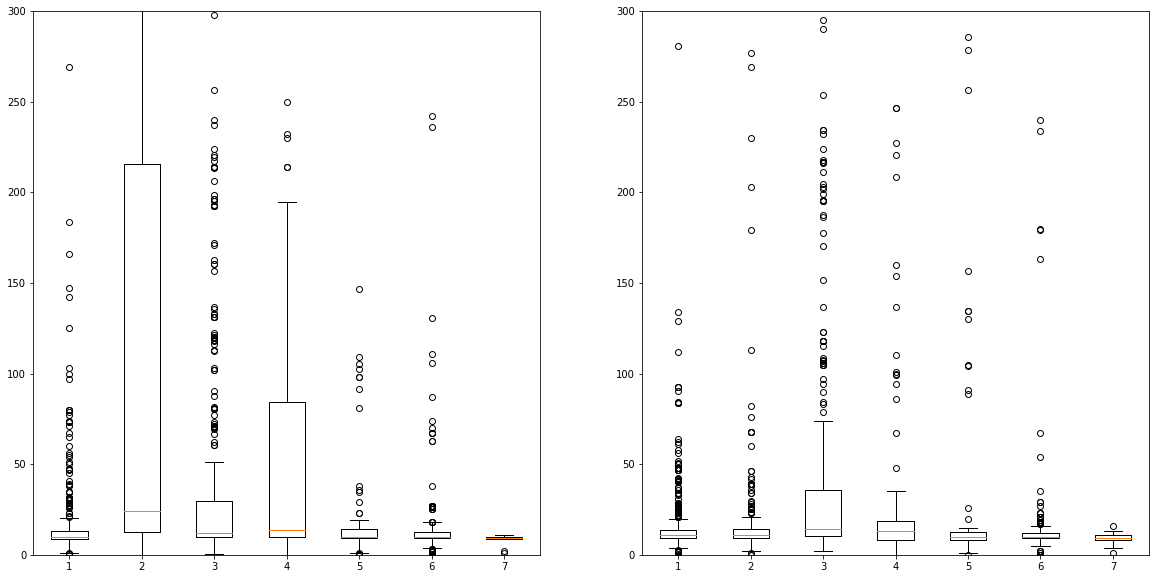

In [408]:
print(errorsWithoutKnowledge == errorsWithKnowledge)
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].boxplot(errorsWithoutKnowledge, 0)
ax[0].set_ylim([0, 300])
ax[1].boxplot(errorsWithKnowledge, 0)
ax[1].set_ylim([0, 300])
pass